In [ ]:
# config
import os
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, BertTokenizer
from torch.utils.data import Dataset, DataLoader, Sampler
from transformers import BertModel, AutoModel
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from time import time, localtime, strftime
from bisect import bisect
from functools import cmp_to_key
import json
import matplotlib.pyplot as plt

config = {
    "data_path": "../AI4Code_data/train/",
    "train_orders_path": "../AI4Code_data/train_orders.csv",
    
    "code_model_name": "microsoft/codebert-base",
    "text_model_name": "bert-base-multilingual-uncased",
    
    "train_size": 0.7,
    "valid_size": 0.2,
    "test_size": 0.1,
    "random_seed": 42,
    
    "train_samples": 100,
    "valid_samples": 10,
    "test_samples": 10,
    
    "hidden_dim": 128,
    "dropout_prob": 0.1,
    "max_length": 128,
    
    "batch_size": 64,
    "epochs": 5,
    "early_stopping": 5,
    "saving_freq": 5,
    "learning_rate": 1e-4
}


In [3]:
# utils
def prepare_folders():
    current_time = strftime("%d.%m.%Y-%H.%M", localtime())
    savedir = f"./checkpoints/{current_time}/"

    if not os.path.exists("./checkpoints"):
        os.mkdir("./checkpoints/")
    if not os.path.exists(savedir):
        os.mkdir(savedir)
    else:
        for root, dirs, files in os.walk(savedir, topdown=False):
            for name in files:
                os.remove(os.path.join(root, name))
            for name in dirs:
                os.rmdir(os.path.join(root, name))

    return savedir


def get_device():
    device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
    return device


def count_inversions(a):
    inversions = 0
    sorted_so_far = []
    for i, u in enumerate(a):
        j = bisect(sorted_so_far, u)
        inversions += i - j
        sorted_so_far.insert(j, u)
    return inversions


def kendall_tau(ground_truth, predictions):
    total_inversions = 0
    total_2max = 0
    for gt, pred in zip(ground_truth, predictions):
        ranks = [gt.index(x) for x in pred]
        total_inversions += count_inversions(ranks)
        n = len(gt)
        total_2max += n * (n - 1)
    return 1 - 4 * total_inversions / total_2max


In [4]:
# Datasets

class Cell:
    def __init__(self, input_ids, att_mask, cell_type):
        self.input_ids = input_ids
        self.att_mask = att_mask
        self.cell_type = cell_type

    def get(self):
        return (self.input_ids, self.att_mask, self.cell_type)


class CellDataset(Dataset):
    def __init__(self, path, data, code_tokenizer, text_tokenizer, max_length):
        self.data = data
        self.code_tokenizer = code_tokenizer
        self.text_tokenizer = text_tokenizer
        self.max_length = max_length
        self.files = {}

        for filename in tqdm(self.data.index, desc="Processing dataset"):
            cells_dict = {}
            cells = self.data.loc[filename, "cell_order"]
            with open(f"{path}{filename}.json") as file:
                json_code = json.load(file)
            for cell in cells:
                input_ids, att_mask, cell_type = self.prepare_data(
                    json_code["cell_type"][cell], json_code["source"][cell]
                )
                cells_dict[cell] = Cell(input_ids, att_mask, cell_type)
            self.files[filename] = cells_dict

    def __len__(self):
        pass

    def __getitem__(self, idx):
        pass

    def prepare_data(self, cell_type, cell_content):
        if cell_type == "code":
            tokenizer = self.code_tokenizer
            type_label = 1
        else:
            tokenizer = self.text_tokenizer
            type_label = 0

        tokens = tokenizer(
            cell_content,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
            return_tensors="pt",
        )
    
        type_tensor = torch.tensor([type_label], dtype=torch.long)

        return (tokens["input_ids"], tokens["attention_mask"], type_tensor)


class TrainValCellDataset(CellDataset):
    def __init__(self, path, data, code_tokenizer, text_tokenizer, max_length):
        super().__init__(path, data, code_tokenizer, text_tokenizer, max_length)

        n_pair = 0
        for row_index in self.data.index:
            n_pair += len(self.data.loc[row_index, "cell_order"]) - 1
        self.n_pair = n_pair

    def __len__(self):
        return self.n_pair

    def __getitem__(self, idx):
        filename = idx[0]
        first_cell_id = idx[1]
        second_cell_id = idx[2]

        first_position = self.data.loc[filename, "cell_order"].index(first_cell_id)
        second_position = self.data.loc[filename, "cell_order"].index(second_cell_id)
        order = 0 if first_position < second_position else 1

        return ((self.files[filename][first_cell_id].get(), self.files[filename][second_cell_id].get()), order)


class TestCellDataset(CellDataset):
    def __init__(self, path, data, code_tokenizer, text_tokenizer, max_length):
        super().__init__(path, data, code_tokenizer, text_tokenizer, max_length)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        file_id = self.data.iloc[idx].name
        correct_order = self.data.iloc[idx].item()
        random_order = correct_order.copy()
        np.random.shuffle(random_order)

        cells = []
        for index in random_order:
            input_ids, att_mask, cell_type = self.files[file_id][index].get()
            cells.append([index, input_ids, att_mask, cell_type])

        return cells, correct_order


class CellSampler(Sampler):
    def __init__(self, data, seed=None):
        self.data = data
        self.seed = seed
        n_pair = 0
        for row_index in self.data.index:
            n_pair += len(self.data.loc[row_index, "cell_order"]) - 1
        self.n_pair = n_pair

    def __len__(self):
        return self.n_pair

    def __iter__(self):
        pairs = []
        for row_index in self.data.index:
            cells = self.data.loc[row_index, "cell_order"].copy()
            if self.seed:
                rng = np.random.default_rng(self.seed)
                rng.shuffle(cells)
            else:
                np.random.shuffle(cells)
            for cell_index in range(len(cells) - 1):
                pairs.append([row_index, cells[cell_index], cells[cell_index + 1]])

        for pair in pairs:
            yield pair

In [8]:
# model 
class OrderPredictionModel(nn.Module):
    def __init__(self, hidden_dim, dropout_prob=0.1):
        super(OrderPredictionModel, self).__init__()

        self.bert_text = BertModel.from_pretrained(config["text_model_name"])
        self.codebert = AutoModel.from_pretrained(config["code_model_name"])

        self.type_embedding = nn.Embedding(2, 8)
        self.fc1 = nn.Linear(768 * 2 + 8 * 2, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_dim, 1)

    @staticmethod
    def _get_batch_embeddings(input_ids, attention_mask, cell_type, code_model, text_model):
        device = input_ids.device
        batch_size = input_ids.size(0)
        hidden_size = code_model.config.hidden_size
        embeddings = torch.zeros(batch_size, hidden_size, device=device, dtype=torch.float32)

        code_mask = (cell_type == 1)
        text_mask = (cell_type == 0)

        if code_mask.any():
            code_indices = code_mask.nonzero(as_tuple=True)[0]
            code_input_ids = input_ids[code_indices]
            code_attention_mask = attention_mask[code_indices]
            out_code = code_model(code_input_ids, attention_mask=code_attention_mask).pooler_output
            embeddings[code_indices] = out_code

        if text_mask.any():
            text_indices = text_mask.nonzero(as_tuple=True)[0]
            text_input_ids = input_ids[text_indices]
            text_attention_mask = attention_mask[text_indices]
            out_text = text_model(text_input_ids, attention_mask=text_attention_mask).pooler_output
            embeddings[text_indices] = out_text

        return embeddings

    def forward(self, input_ids1, att_mask1, cell_type1, input_ids2, att_mask2, cell_type2):
        embedding1 = self._get_batch_embeddings(input_ids1, att_mask1, cell_type1, 
                                                code_model=self.codebert, text_model=self.bert_text)

        embedding2 = self._get_batch_embeddings(input_ids2, att_mask2, cell_type2, 
                                               code_model=self.codebert, text_model=self.bert_text)

        type_emb1 = self.type_embedding(cell_type1)
        type_emb2 = self.type_embedding(cell_type2)

        combined = torch.cat([embedding1, type_emb1, embedding2, type_emb2], dim=1)
        x = torch.relu(self.bn1(self.fc1(combined)))
        x = self.dropout(x)
        output = torch.sigmoid(self.fc2(x))

        return output.squeeze(1)


In [9]:
# train/test
class Trainer:
    def __init__(
        self,
        model,
        train_dataloader,
        valid_dataloader,
        savedir,
        device,
        epochs=10,
        early_stopping=5,
        saving_freq=5,
        lr=1e-4,
    ):
        self.device = device
        self.model = model.to(device)
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.criterion = nn.BCELoss()
        self.optimizer = optim.NAdam(self.model.parameters(), lr=lr)
        self.epochs = epochs
        self.early_stopping = early_stopping
        self.best_score = -float("inf")
        self.best_model = None
        self.savedir = savedir
        self.saving_freq = saving_freq

        self.train_losses = []
        self.valid_kendalls = []

    def train(self):
        early_stopping_remaining = self.early_stopping
        print("*" * 80)
        print(f"Train model")

        for epoch in range(1, self.epochs + 1):
            print("*" * 80)
            print(f"Epoch {epoch}/{self.epochs}")
            start_time = time()
            train_loss = self._train_one_epoch()
            valid_score = self._validate()

            self.train_losses.append(train_loss)
            self.valid_kendalls.append(valid_score)
            
            print(f"Train loss: {train_loss:.4f}, Valid accuracy: {valid_score:.4f}")
            print(f"Epoch execution time: {time() - start_time:.2f} seconds")

            if valid_score > self.best_score:
                early_stopping_remaining = self.early_stopping
                self.best_score = valid_score
                self.best_model = {k: v.cpu() for k, v in self.model.state_dict().items()}
                print(f"New best model saved with valid accuracy: {valid_score:.4f}")
            else:
                early_stopping_remaining -= 1

            if epoch % self.saving_freq == 0:
                self._save_checkpoint(epoch, train_loss)

            if not early_stopping_remaining:
                print(f"Training stopped at {epoch} epoch")
                break

        if self.best_model:
            torch.save(self.best_model, f"{self.savedir}best_model.pt")
            print("Best model saved as 'best_model.pt'.")
        
        return self.train_losses, self.valid_kendalls

    def _train_one_epoch(self):
        self.model.train()
        train_loss = 0
        n_batches = 0

        for (first_cell, second_cell), train_label in tqdm(self.train_dataloader, desc="Training"):
            self.optimizer.zero_grad()
            output = self.model(
                first_cell[0].squeeze(1).to(self.device),
                first_cell[1].squeeze(1).to(self.device),
                first_cell[2].squeeze(1).to(self.device),
                second_cell[0].squeeze(1).to(self.device),
                second_cell[1].squeeze(1).to(self.device),
                second_cell[2].squeeze(1).to(self.device),
            )
            loss = self.criterion(output, train_label.float().to(self.device))
            loss.backward()
            self.optimizer.step()

            train_loss += loss.item()
            n_batches += 1

        return train_loss / n_batches

    def _validate(self):
        self.model.eval()
        score = 0
        n_batches = 0

        with torch.no_grad():
            for (first_cell, second_cell), correct_order in tqdm(self.valid_dataloader, desc="Validating"):
                n_batches += 1
                output = self.model(
                    first_cell[0].squeeze(1).to(self.device),
                    first_cell[1].squeeze(1).to(self.device),
                    first_cell[2].squeeze(1).to(self.device),
                    second_cell[0].squeeze(1).to(self.device),
                    second_cell[1].squeeze(1).to(self.device),
                    second_cell[2].squeeze(1).to(self.device),
                )

                output += 0.5
                order = output.to(dtype=torch.int32).cpu()
                score += sum(order == correct_order).sum() / correct_order.shape[0]

        score /= n_batches
        return score

    def _save_checkpoint(self, epoch, train_loss):
        checkpoint = {
            "epoch": epoch,
            "model_state_dict": {k: v.cpu() for k, v in self.model.state_dict().items()},
            "optimizer_state_dict": self.optimizer.state_dict(),
            "train_loss": train_loss,
        }
        checkpoint_path = f"{self.savedir}checkpoint_epoch_{epoch}.pt"
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}.")


class Tester:
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def test(self, test_dataloader):
        self.model.to(self.device)
        self.model.eval()
        true_order = []
        predicted_order = []

        with torch.no_grad():
            for cells, correct_order in tqdm(test_dataloader, desc="Testing"):
                sorted_cells = sorted(cells, key=cmp_to_key(self._custom_compare))
                sorted_order = [cell[0] for cell in sorted_cells]
                true_order.append(correct_order)
                predicted_order.append(sorted_order)

        return kendall_tau(true_order, predicted_order)

    def _custom_compare(self, cell1, cell2):
        result = self.model(
            cell1[1].squeeze(0).to(self.device),
            cell1[2].squeeze(0).to(self.device),
            cell1[3].squeeze(0).to(self.device),
            cell2[1].squeeze(0).to(self.device),
            cell2[2].squeeze(0).to(self.device),
            cell2[3].squeeze(0).to(self.device),
        )

        if result.item() <= 0.5:
            return -1
        else:
            return 1


In [10]:
# загрузка данных

print("*" * 80)
print("Reading data")

code_tokenizer = AutoTokenizer.from_pretrained(config["code_model_name"])
text_tokenizer = BertTokenizer.from_pretrained(config["text_model_name"])

info = pd.read_csv(config["train_orders_path"], index_col="id")
info["cell_order"] = info["cell_order"].apply(lambda x: x.split())
indeces = list(info.index)

rng = np.random.default_rng(config["random_seed"])
rng.shuffle(indeces)

train_border = int(config["train_size"] * len(indeces))
valid_border = int((config["train_size"] + config["valid_size"]) * len(indeces))

train_data = info.loc[indeces[:train_border]]
valid_data = info.loc[indeces[train_border:valid_border]]
test_data = info.loc[indeces[valid_border:]]

# подвыборки для теста
train_data_short = train_data.iloc[:config["train_samples"]]
valid_data_short = valid_data.iloc[:config["valid_samples"]]
test_data_short = test_data.iloc[:config["test_samples"]]

print(f"Train samples: {len(train_data_short)}")
print(f"Validation samples: {len(valid_data_short)}")
print(f"Test samples: {len(test_data_short)}")

# datasets and dataloaders
print("*" * 80)
print("Creating datasets and dataloaders")

train_dataset = TrainValCellDataset(
    config["data_path"], 
    train_data_short, 
    code_tokenizer, 
    text_tokenizer, 
    config["max_length"]
)
train_sampler = CellSampler(train_data_short)
train_dataloader = DataLoader(
    train_dataset, 
    config["batch_size"], 
    drop_last=True, 
    sampler=train_sampler
)

valid_dataset = TrainValCellDataset(
    config["data_path"], 
    valid_data_short, 
    code_tokenizer, 
    text_tokenizer, 
    config["max_length"]
)
valid_sampler = CellSampler(valid_data_short, config["random_seed"])
valid_dataloader = DataLoader(
    valid_dataset, 
    config["batch_size"], 
    drop_last=True, 
    sampler=valid_sampler
)

test_dataset = TestCellDataset(
    config["data_path"], 
    test_data_short, 
    code_tokenizer, 
    text_tokenizer, 
    config["max_length"]
)
test_dataloader = DataLoader(test_dataset, 1, shuffle=False)

print(f"Train dataloader length: {len(train_dataloader)}")
print(f"Validation dataloader length: {len(valid_dataloader)}")
print(f"Test dataloader length: {len(test_dataloader)}")

********************************************************************************
Reading data
Train samples: 10
Validation samples: 10
Test samples: 10
********************************************************************************
Creating datasets and dataloaders


Processing dataset: 100%|██████████| 10/10 [00:00<00:00, 126.95it/s]

Train dataloader length: 7
Validation dataloader length: 6
Test dataloader length: 10


device: mps
********************************************************************************
Train model
********************************************************************************
Epoch 1/5


Validating: 100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


Train loss: 0.7347, Valid accuracy: 0.5130
Epoch execution time: 100.95 seconds
New best model saved with valid accuracy: 0.5130
********************************************************************************
Epoch 2/5


Validating: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Train loss: 0.7329, Valid accuracy: 0.5000
Epoch execution time: 75.73 seconds
********************************************************************************
Epoch 3/5


Validating: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Train loss: 0.6591, Valid accuracy: 0.5104
Epoch execution time: 29.83 seconds
********************************************************************************
Epoch 4/5


Validating: 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


Train loss: 0.5718, Valid accuracy: 0.5599
Epoch execution time: 29.09 seconds
New best model saved with valid accuracy: 0.5599
********************************************************************************
Epoch 5/5


Validating: 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


Train loss: 0.5401, Valid accuracy: 0.5964
Epoch execution time: 30.20 seconds
New best model saved with valid accuracy: 0.5964
Checkpoint saved at ./checkpoints/23.03.2025-11.42/checkpoint_epoch_5.pt.
Best model saved as 'best_model.pt'.


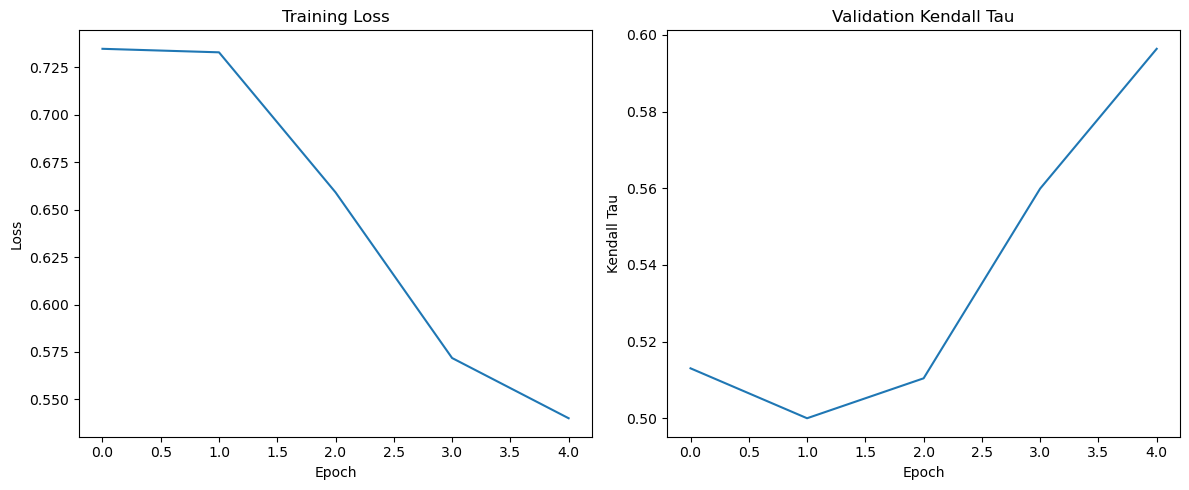

In [11]:
# train

model = OrderPredictionModel(config["hidden_dim"], config["dropout_prob"])
savedir = prepare_folders()
device = get_device()
print(f"device: {device}")

trainer = Trainer(
    model=model,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    savedir=savedir,
    device=device,
    epochs=config["epochs"],
    early_stopping=config["early_stopping"],
    saving_freq=config["saving_freq"],
    lr=config["learning_rate"],
)

train_losses, valid_kendalls = trainer.train()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(valid_kendalls)
plt.title('Validation Kendall Tau')
plt.xlabel('Epoch')
plt.ylabel('Kendall Tau')

plt.tight_layout()
plt.savefig(os.path.join(savedir, 'training_curves.png'))
plt.show()

In [12]:
# NB! нужно тестировать на очень небольшом семпле, остальное кидать в сабмишн

print("*" * 80)
print("Testing model")

best_model_weights = torch.load(f"{savedir}best_model.pt")
model.load_state_dict(best_model_weights)

tester = Tester(model, device)
result = tester.test(test_dataloader)
print(f"Kendall Tau local score: {result}")

********************************************************************************
Testing model


Testing:   0%|          | 0/10 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [14]:
print("*" * 80)
print("Creating submission file")

best_model_weights = torch.load(f"{savedir}best_model.pt")
model.load_state_dict(best_model_weights)
model.to(device)

def generate_submission(model, device, test_path, submission_path):
    test_files = os.listdir(test_path)
    test_files = [f for f in test_files if f.endswith('.json')]
    
    submission_data = {'id': [], 'cell_order': []}
    
    print(f"Generating predictions for {len(test_files)} test notebooks...")
    
    for test_file in tqdm(test_files, desc="Creating submission"):
        notebook_id = test_file.split('.')[0]
        
        with open(os.path.join(test_path, test_file), 'r') as f:
            notebook = json.load(f)
        
        cell_inputs = []
        cell_ids = []
        
        for cell_id in notebook['source']:
            cell_type = notebook['cell_type'][cell_id]
            source = notebook['source'][cell_id]
            
            if cell_type == 'code':
                tokenizer = code_tokenizer
                cell_type_id = 1
            else:
                tokenizer = text_tokenizer
                cell_type_id = 0
                
            tokens = tokenizer(
                source,
                padding="max_length",
                max_length=config["max_length"],
                truncation=True,
                return_tensors="pt"
            )

            cell_inputs.append({
                'input_ids': tokens['input_ids'],
                'attention_mask': tokens['attention_mask'],
                'cell_type': torch.tensor([cell_type_id], dtype=torch.long)
            })
            cell_ids.append(cell_id)
        
        model.eval()
        with torch.no_grad():
            sorted_ids = []
            for i in range(len(cell_ids) - 1):
                remaining_indices = [j for j in range(len(cell_ids)) if cell_ids[j] not in sorted_ids]
                
                best_score = -float('inf')
                best_index = -1
                
                if i == 0:
                    for idx in remaining_indices:
                        cell_i = cell_inputs[idx]
                        cell_type = cell_i['cell_type'].item()
                        
                        score = -1 if cell_type == 1 else 0
                        
                        if cell_type == 0:
                            source = notebook['source'][cell_ids[idx]]
                            if source.startswith('#') or 'introduction' in source.lower():
                                score += 2
                            
                        if score > best_score:
                            best_score = score
                            best_index = idx
                
                else:
                    prev_cell_idx = cell_ids.index(sorted_ids[-1])
                    prev_cell = cell_inputs[prev_cell_idx]
                    
                    for idx in remaining_indices:
                        curr_cell = cell_inputs[idx]
                        
                        output = model(
                            prev_cell['input_ids'].to(device),
                            prev_cell['attention_mask'].to(device),
                            prev_cell['cell_type'].to(device),
                            curr_cell['input_ids'].to(device),
                            curr_cell['attention_mask'].to(device),
                            curr_cell['cell_type'].to(device)
                        )
                        
                        score = output.item()
                        
                        if score > best_score:
                            best_score = score
                            best_index = idx
                
                sorted_ids.append(cell_ids[best_index])
            
            for remaining_id in cell_ids:
                if remaining_id not in sorted_ids:
                    sorted_ids.append(remaining_id)

        submission_data['id'].append(notebook_id)
        submission_data['cell_order'].append(' '.join(sorted_ids))
    
    submission_df = pd.DataFrame(submission_data)
    submission_df.to_csv(submission_path, index=False)
    print(f"Submission file saved to {submission_path}")
    return submission_df

test_path = "../AI4Code_data/test/"
submission_path = f"{savedir}submission.csv"
submission = generate_submission(model, device, test_path, submission_path)

print("\nSample of submission file:")
print(submission.head())


********************************************************************************
Creating submission file
Generating predictions for 4 test notebooks...


Creating submission:   0%|          | 0/4 [00:46<?, ?it/s]


KeyboardInterrupt: 